# Lab: AG-UI Integration with Microsoft Agent Framework

**Duration:** 20 minutes  
**Objective:** Build web-based AI agent applications with real-time streaming and interactive UI components

---

## What is AG-UI?

> [AG-UI](https://docs.ag-ui.com/introduction) is a protocol that enables you to build web-based AI agent applications with advanced features like real-time streaming, state management, and interactive UI components.
>
> — [AG-UI Integration](https://learn.microsoft.com/agent-framework/integrations/ag-ui/)

### AG-UI Features

| Feature | Description |
|---------|-------------|
| **Remote Agent Hosting** | Deploy AI agents as web services accessible by multiple clients |
| **Real-time Streaming** | Stream agent responses using Server-Sent Events (SSE) |
| **Session Management** | Maintain conversation context across multiple requests |
| **Human-in-the-Loop** | Approval workflows where users confirm actions before execution |
| **State Synchronization** | Bidirectional state sync between client and server |
| **Generative UI** | Custom UI components rendered based on tool calls |

### AG-UI vs Direct Agent Usage

| Feature | Direct Agent Usage | AG-UI Integration |
|---------|-------------------|-------------------|
| Deployment | Embedded in application | Remote service via HTTP |
| Client Access | Single application | Multiple clients (web, mobile) |
| Streaming | In-process async iteration | Server-Sent Events (SSE) |
| State Management | Application-managed | Protocol-level state snapshots |
| Approval Workflows | Custom implementation | Built-in protocol support |

---

## Prerequisites

- Python 3.10+
- Azure OpenAI service endpoint and deployment configured
- Azure CLI authenticated (`az login`)
- User has the `Cognitive Services OpenAI Contributor` role

---

## Step 1: Environment Setup

Install the AG-UI integration package which includes FastAPI and all required dependencies.

In [ ]:
# Install AG-UI integration (includes agent-framework-core, fastapi, uvicorn)
%pip install agent-framework-ag-ui --pre python-dotenv --quiet

In [ ]:
import os
from typing import Annotated, Any
from pydantic import Field
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Configuration
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4o")

if not AZURE_OPENAI_ENDPOINT:
    print("⚠️  Set AZURE_OPENAI_ENDPOINT in your .env file")
    print("   For this lab, we'll use mock responses to demonstrate AG-UI concepts")
    USE_MOCK = True
else:
    USE_MOCK = False
    print(f"✓ Azure OpenAI endpoint: {AZURE_OPENAI_ENDPOINT}")
    print(f"✓ Deployment: {AZURE_OPENAI_DEPLOYMENT_NAME}")

---

## Step 2: AG-UI Architecture Overview
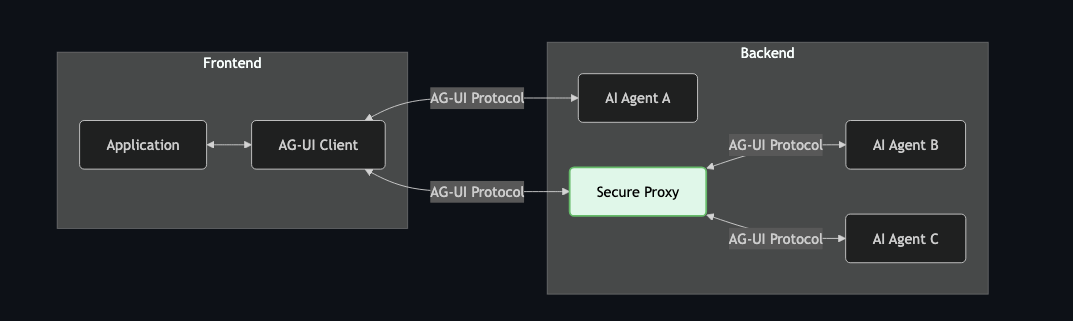

- Application: User-facing apps (i.e. chat or any AI-enabled application).
- AG-UI Client: Generic communication clients like HttpAgent or specialized clients for connecting to existing protocols.
- Agents: Backend AI agents that process requests and generate streaming responses.
- Secure Proxy: Backend services that provide additional capabilities and act as a secure proxy.

### Component Stack

```
┌─────────────────┐
│  Web Client     │
│  (Browser/App)  │
└────────┬────────┘
         │ HTTP POST + SSE
         ▼
┌─────────────────────────┐
│  FastAPI Endpoint       │
│  (add_agent_framework_  │
│   fastapi_endpoint)     │
└────────┬────────────────┘
         │
         ▼
┌─────────────────────────┐
│  AgentFrameworkAgent    │
│  (Protocol Wrapper)     │
└────────┬────────────────┘
         │
         ▼
┌─────────────────────────┐
│  ChatAgent              │
│  (Agent Framework)      │
└────────┬────────────────┘
         │
         ▼
┌─────────────────────────┐
│  Chat Client            │
│  (Azure OpenAI, etc.)   │
└─────────────────────────┘
```

### Key Components

| Component | Description |
|-----------|-------------|
| **FastAPI Endpoint** | HTTP endpoint that handles SSE streaming and request routing |
| **AgentFrameworkAgent** | Lightweight wrapper adapting agents to AG-UI protocol |
| **Event Bridge** | Converts Agent Framework events to AG-UI protocol events |
| **Message Adapters** | Bidirectional conversion between AG-UI and Agent Framework message formats |

### How Agent Framework Maps to AG-UI

| Agent Framework Concept | AG-UI Equivalent | Description |
|------------------------|------------------|-------------|
| `ChatAgent` | Agent Endpoint | Each agent becomes an HTTP endpoint |
| `agent.run()` | HTTP POST Request | Client sends messages via HTTP |
| `agent.run_stream()` | Server-Sent Events | Streaming responses via SSE |
| Agent response updates | AG-UI Events | `TEXT_MESSAGE_CONTENT`, `TOOL_CALL_START`, etc. |
| Function tools (`@tool`) | Backend Tools | Executed on server, results streamed to client |

> Learn more: [AG-UI Architecture](https://learn.microsoft.com/agent-framework/integrations/ag-ui/#architecture-overview)

---

## Step 3: Define Backend Tools

### Backend Tool Rendering

> Backend tool rendering means function tools are defined on the server, the AI agent decides when to call these tools, tools execute on the backend (server-side), and tool call events and results are streamed to the client in real-time.
>
> — [Backend Tool Rendering](https://learn.microsoft.com/agent-framework/integrations/ag-ui/backend-tool-rendering)

This approach provides:
- **Security**: Sensitive operations stay on the server
- **Consistency**: All clients use the same tool implementations
- **Transparency**: Clients can display tool execution progress
- **Flexibility**: Update tools without changing client code

In [ ]:
from agent_framework import tool

# Define function tools that will be executed on the backend
# Results are automatically streamed to the client

@tool
def get_weather(
    location: Annotated[str, Field(description="The city to get weather for")],
) -> str:
    """Get the current weather for a location."""
    # Simulated weather data
    weather_data = {
        "Seattle": {"temp": 18, "condition": "Cloudy", "humidity": 75},
        "San Francisco": {"temp": 22, "condition": "Sunny", "humidity": 60},
        "New York": {"temp": 25, "condition": "Partly cloudy", "humidity": 65},
        "London": {"temp": 15, "condition": "Rainy", "humidity": 85},
    }
    data = weather_data.get(location, {"temp": 20, "condition": "Unknown", "humidity": 50})
    return f"Weather in {location}: {data['condition']}, {data['temp']}°C, {data['humidity']}% humidity"


@tool
def search_restaurants(
    location: Annotated[str, Field(description="The city to search in")],
    cuisine: Annotated[str, Field(description="Type of cuisine")] = "any",
) -> dict[str, Any]:
    """Search for restaurants in a location."""
    # Simulated restaurant data
    return {
        "location": location,
        "cuisine": cuisine,
        "results": [
            {"name": "The Golden Fork", "cuisine": cuisine if cuisine != "any" else "Italian", "rating": 4.5, "price": "$$"},
            {"name": "Spice Haven", "cuisine": "Indian", "rating": 4.7, "price": "$$"},
            {"name": "Green Leaf", "cuisine": "Vegetarian", "rating": 4.3, "price": "$"},
        ]
    }


@tool
def book_reservation(
    restaurant_name: Annotated[str, Field(description="Name of the restaurant")],
    party_size: Annotated[int, Field(description="Number of guests")],
    date: Annotated[str, Field(description="Reservation date (YYYY-MM-DD)")],
    time: Annotated[str, Field(description="Reservation time (HH:MM)")] = "19:00",
) -> dict[str, Any]:
    """Book a reservation at a restaurant. Use this after searching for restaurants."""
    return {
        "status": "confirmed",
        "confirmation_id": f"RES-{hash(restaurant_name + date) % 10000:04d}",
        "restaurant": restaurant_name,
        "party_size": party_size,
        "date": date,
        "time": time,
    }


print("✓ Backend tools defined:")
print("  - get_weather: Get current weather for a city")
print("  - search_restaurants: Find restaurants by location/cuisine")
print("  - book_reservation: Make a restaurant reservation")

---

## Step 4: Create the AG-UI Server

The AG-UI server hosts your AI agent and exposes it via HTTP endpoints using FastAPI.

### Server Setup Code

Here's the complete server implementation that we'll run in a separate terminal:

In [ ]:
# This cell creates the server.py file for running in a terminal

server_code = '''
"""AG-UI server with backend tool rendering."""

import os
from typing import Annotated, Any

from agent_framework import ChatAgent, tool
from agent_framework.azure import AzureOpenAIChatClient
from agent_framework_ag_ui import add_agent_framework_fastapi_endpoint
from azure.identity import AzureCliCredential
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import Field
from dotenv import load_dotenv

load_dotenv()

# Define function tools
@tool
def get_weather(
    location: Annotated[str, Field(description="The city to get weather for")],
) -> str:
    """Get the current weather for a location."""
    weather_data = {
        "Seattle": {"temp": 18, "condition": "Cloudy", "humidity": 75},
        "San Francisco": {"temp": 22, "condition": "Sunny", "humidity": 60},
        "New York": {"temp": 25, "condition": "Partly cloudy", "humidity": 65},
        "London": {"temp": 15, "condition": "Rainy", "humidity": 85},
    }
    data = weather_data.get(location, {"temp": 20, "condition": "Unknown", "humidity": 50})
    return f"Weather in {location}: {data[\'condition\']}, {data[\'temp\']}°C, {data[\'humidity\']}% humidity"


@tool
def search_restaurants(
    location: Annotated[str, Field(description="The city to search in")],
    cuisine: Annotated[str, Field(description="Type of cuisine")] = "any",
) -> dict[str, Any]:
    """Search for restaurants in a location."""
    return {
        "location": location,
        "cuisine": cuisine,
        "results": [
            {"name": "The Golden Fork", "cuisine": cuisine if cuisine != "any" else "Italian", "rating": 4.5, "price": "$$"},
            {"name": "Spice Haven", "cuisine": "Indian", "rating": 4.7, "price": "$$"},
            {"name": "Green Leaf", "cuisine": "Vegetarian", "rating": 4.3, "price": "$"},
        ]
    }


# Read configuration
endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")
deployment_name = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4o")

if not endpoint:
    raise ValueError("AZURE_OPENAI_ENDPOINT environment variable is required")

chat_client = AzureOpenAIChatClient(
    credential=AzureCliCredential(),
    endpoint=endpoint,
    deployment_name=deployment_name,
)

# Create agent with tools
agent = ChatAgent(
    name="TravelAssistant",
    instructions="""You are a helpful travel assistant. Use the available tools to help users:
    - Check weather conditions at destinations
    - Find restaurants by location and cuisine type
    
    Be friendly and provide helpful recommendations based on the data you gather.""",
    chat_client=chat_client,
    tools=[get_weather, search_restaurants],
)

# Create FastAPI app with CORS for web clients
app = FastAPI(title="AG-UI Travel Assistant")
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Register the AG-UI endpoint
add_agent_framework_fastapi_endpoint(app, agent, "/")

if __name__ == "__main__":
    import uvicorn
    print("Starting AG-UI server at http://127.0.0.1:8888")
    uvicorn.run(app, host="127.0.0.1", port=8888)
'''

with open("agui_server.py", "w") as f:
    f.write(server_code.strip())

print("✓ Server code saved to agui_server.py")
print("\nTo run the server, open a terminal and execute:")
print("  python agui_server.py")
print("\nOr with uvicorn:")
print("  uvicorn agui_server:app --host 127.0.0.1 --port 8888")

---

## Step 5: Understanding AG-UI Events

### Event Types

When interacting with an AG-UI server, the client receives several event types:

```python
# Run lifecycle events
{"type": "RUN_STARTED", "threadId": "...", "runId": "..."}
{"type": "RUN_FINISHED", "threadId": "...", "runId": "..."}
{"type": "RUN_ERROR", "message": "..."}

# Text message events (streaming)
{"type": "TEXT_MESSAGE_START", "messageId": "...", "role": "assistant"}
{"type": "TEXT_MESSAGE_CONTENT", "messageId": "...", "delta": "Hello"}
{"type": "TEXT_MESSAGE_END", "messageId": "..."}

# Tool call events
{"type": "TOOL_CALL_START", "toolCallId": "...", "toolCallName": "get_weather"}
{"type": "TOOL_CALL_ARGS", "toolCallId": "...", "delta": "{\"location\": \"Seattle\"}"}
{"type": "TOOL_CALL_END", "toolCallId": "..."}
{"type": "TOOL_CALL_RESULT", "toolCallId": "...", "content": "Weather in Seattle: ..."}
```

### Event Flow Diagram

```
Client                          Server
  │                               │
  │ POST /                        │
  │ {"messages": [...]}           │
  │──────────────────────────────>│
  │                               │
  │<─────────── RUN_STARTED ──────│
  │                               │
  │<──── TEXT_MESSAGE_START ──────│
  │<──── TEXT_MESSAGE_CONTENT ────│ (repeated)
  │<──── TEXT_MESSAGE_END ────────│
  │                               │
  │<──── TOOL_CALL_START ─────────│
  │<──── TOOL_CALL_ARGS ──────────│
  │<──── TOOL_CALL_END ───────────│
  │<──── TOOL_CALL_RESULT ────────│
  │                               │
  │<──── TEXT_MESSAGE_START ──────│ (agent responds with results)
  │<──── TEXT_MESSAGE_CONTENT ────│
  │<──── TEXT_MESSAGE_END ────────│
  │                               │
  │<────────── RUN_FINISHED ──────│
  │                               │
```

---

## Step 6: Create an AG-UI Client

The AG-UI client connects to the remote server and displays streaming responses.

> The `AGUIChatClient` sends HTTP POST requests and processes SSE streams, parsing incoming events into `AgentResponseUpdate` objects.
>
> — [AG-UI Getting Started](https://learn.microsoft.com/agent-framework/integrations/ag-ui/getting-started)

In [ ]:
# Create client code that can connect to the AG-UI server

client_code = '''
"""AG-UI client with tool event handling."""

import asyncio
import os

from agent_framework import ChatAgent, ToolCallContent, ToolResultContent
from agent_framework_ag_ui import AGUIChatClient

async def main():
    """Main client loop with tool event display."""
    server_url = os.environ.get("AGUI_SERVER_URL", "http://127.0.0.1:8888/")
    print(f"Connecting to AG-UI server at: {server_url}\n")

    # Create AG-UI chat client
    chat_client = AGUIChatClient(server_url=server_url)

    # Create agent with the chat client
    agent = ChatAgent(
        name="ClientAgent",
        chat_client=chat_client,
        instructions="You are a helpful assistant.",
    )

    # Get a thread for conversation continuity
    thread = agent.get_new_thread()

    try:
        while True:
            message = input("\nUser (:q or quit to exit): ")
            if not message.strip():
                continue

            if message.lower() in (":q", "quit"):
                break

            print("\nAssistant: ", end="", flush=True)
            async for update in agent.run_stream(message, thread=thread):
                # Display text content (cyan)
                if update.text:
                    print(f"\033[96m{update.text}\033[0m", end="", flush=True)

                # Display tool calls and results
                for content in update.contents:
                    if isinstance(content, ToolCallContent):
                        print(f"\n\033[95m[Calling tool: {content.name}]\033[0m")
                    elif isinstance(content, ToolResultContent):
                        result_text = content.result if isinstance(content.result, str) else str(content.result)
                        print(f"\033[94m[Tool result: {result_text[:100]}...]\033[0m")

            print("\n")

    except KeyboardInterrupt:
        print("\n\nExiting...")
    except Exception as e:
        print(f"\n\033[91mError: {e}\033[0m")

if __name__ == "__main__":
    asyncio.run(main())
'''

with open("agui_client.py", "w") as f:
    f.write(client_code.strip())

print("✓ Client code saved to agui_client.py")
print("\nTo run the client (after starting the server):")
print("  python agui_client.py")

---

## Step 7: Testing with curl

You can test the AG-UI server directly using curl to see the raw SSE events:

In [ ]:
# This shows the curl command to test the AG-UI server

curl_command = """
curl -N http://127.0.0.1:8888/ \\
  -H "Content-Type: application/json" \\
  -H "Accept: text/event-stream" \\
  -d '{
    "messages": [
      {"role": "user", "content": "What is the weather in Seattle?"}
    ]
  }'
"""

print("Test the AG-UI server with curl:")
print("="*60)
print(curl_command)
print("="*60)
print("\nExpected response (Server-Sent Events):")
print('''
data: {"type":"RUN_STARTED","threadId":"...","runId":"..."}

data: {"type":"TOOL_CALL_START","toolCallId":"...","toolCallName":"get_weather"}

data: {"type":"TOOL_CALL_ARGS","toolCallId":"...","delta":"{\\"location\\": \\"Seattle\\"}"}

data: {"type":"TOOL_CALL_END","toolCallId":"..."}

data: {"type":"TOOL_CALL_RESULT","toolCallId":"...","content":"Weather in Seattle: Cloudy, 18°C..."}

data: {"type":"TEXT_MESSAGE_START","messageId":"...","role":"assistant"}

data: {"type":"TEXT_MESSAGE_CONTENT","messageId":"...","delta":"The weather"}

data: {"type":"TEXT_MESSAGE_CONTENT","messageId":"...","delta":" in Seattle"}
...
data: {"type":"TEXT_MESSAGE_END","messageId":"..."}

data: {"type":"RUN_FINISHED","threadId":"...","runId":"..."}
''')

---

## Step 8: Simulating AG-UI Events (Demo)

Let's simulate what the AG-UI event stream looks like without needing the actual server running:

In [ ]:
import json
import asyncio
from datetime import datetime
from IPython.display import display, HTML, clear_output
import time

# Simulated AG-UI event stream
def simulate_agui_events():
    """Simulate AG-UI server events for demonstration."""
    thread_id = f"thread_{datetime.now().strftime('%H%M%S')}"
    run_id = f"run_{hash(thread_id) % 10000:04d}"
    tool_call_id = f"call_{hash(run_id) % 10000:04d}"
    message_id = f"msg_{hash(tool_call_id) % 10000:04d}"
    
    events = [
        # Run starts
        {"type": "RUN_STARTED", "threadId": thread_id, "runId": run_id},
        
        # Tool call for weather
        {"type": "TOOL_CALL_START", "toolCallId": tool_call_id, "toolCallName": "get_weather"},
        {"type": "TOOL_CALL_ARGS", "toolCallId": tool_call_id, "delta": '{"location": "Seattle"}'},
        {"type": "TOOL_CALL_END", "toolCallId": tool_call_id},
        {"type": "TOOL_CALL_RESULT", "toolCallId": tool_call_id, "content": "Weather in Seattle: Cloudy, 18°C, 75% humidity"},
        
        # Agent response
        {"type": "TEXT_MESSAGE_START", "messageId": message_id, "role": "assistant"},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "The weather "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "in Seattle "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "is currently "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "cloudy with "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "a temperature "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "of 18°C "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": message_id, "delta": "and 75% humidity."},
        {"type": "TEXT_MESSAGE_END", "messageId": message_id},
        
        # Run completes
        {"type": "RUN_FINISHED", "threadId": thread_id, "runId": run_id},
    ]
    
    return events


def format_event_html(event):
    """Format an event for HTML display with color coding."""
    event_type = event.get("type", "")
    
    colors = {
        "RUN_STARTED": "#4CAF50",      # Green
        "RUN_FINISHED": "#4CAF50",     # Green
        "RUN_ERROR": "#f44336",        # Red
        "TOOL_CALL_START": "#9C27B0",  # Purple
        "TOOL_CALL_ARGS": "#9C27B0",   # Purple
        "TOOL_CALL_END": "#9C27B0",    # Purple
        "TOOL_CALL_RESULT": "#2196F3", # Blue
        "TEXT_MESSAGE_START": "#FF9800",  # Orange
        "TEXT_MESSAGE_CONTENT": "#00BCD4", # Cyan
        "TEXT_MESSAGE_END": "#FF9800",    # Orange
    }
    
    color = colors.get(event_type, "#757575")
    json_str = json.dumps(event, indent=2)
    
    return f'<pre style="background-color: #1e1e1e; color: {color}; padding: 8px; margin: 4px 0; border-radius: 4px; font-size: 12px;">data: {json_str}</pre>'


# Run the simulation
print("Simulating AG-UI Event Stream")
print("Query: 'What is the weather in Seattle?'")
print("="*60)

events = simulate_agui_events()
html_output = []

for event in events:
    html_output.append(format_event_html(event))
    
display(HTML("".join(html_output)))

---

## Step 9: Building a Simple UI Renderer

Let's create a simple event renderer that demonstrates how a UI could display AG-UI events:

In [ ]:
from IPython.display import display, HTML
import time

class AGUIRenderer:
    """Simple AG-UI event renderer for demonstration."""
    
    def __init__(self):
        self.html_parts = []
        self.current_message = []
        self.tool_calls = {}
    
    def render_event(self, event: dict):
        """Process and render an AG-UI event."""
        event_type = event.get("type", "")
        
        if event_type == "RUN_STARTED":
            self.html_parts.append(
                f'<div style="color: #4CAF50; padding: 4px;">'
                f'▶ Run started (Thread: {event["threadId"][:8]}...)</div>'
            )
            
        elif event_type == "TOOL_CALL_START":
            tool_name = event["toolCallName"]
            self.tool_calls[event["toolCallId"]] = {"name": tool_name, "args": ""}
            self.html_parts.append(
                f'<div style="color: #9C27B0; padding: 4px; margin-top: 8px;">'
                f'🔧 Calling tool: <strong>{tool_name}</strong></div>'
            )
            
        elif event_type == "TOOL_CALL_ARGS":
            self.tool_calls[event["toolCallId"]]["args"] += event["delta"]
            
        elif event_type == "TOOL_CALL_RESULT":
            result = event["content"]
            self.html_parts.append(
                f'<div style="background-color: #e3f2fd; color: #1565c0; padding: 8px; '
                f'margin: 4px 0; border-radius: 4px; font-size: 13px;">'
                f'📊 <strong>Tool Result:</strong> {result}</div>'
            )
            
        elif event_type == "TEXT_MESSAGE_START":
            self.current_message = []
            self.html_parts.append(
                '<div style="margin-top: 12px;"><strong>🤖 Assistant:</strong></div>'
            )
            
        elif event_type == "TEXT_MESSAGE_CONTENT":
            self.current_message.append(event["delta"])
            
        elif event_type == "TEXT_MESSAGE_END":
            message = "".join(self.current_message)
            self.html_parts.append(
                f'<div style="background-color: #f5f5f5; padding: 12px; '
                f'margin: 4px 0; border-radius: 8px; border-left: 4px solid #00bcd4;">'
                f'{message}</div>'
            )
            
        elif event_type == "RUN_FINISHED":
            self.html_parts.append(
                f'<div style="color: #4CAF50; padding: 4px; margin-top: 8px;">'
                f'✅ Run finished</div>'
            )
            
        elif event_type == "RUN_ERROR":
            self.html_parts.append(
                f'<div style="color: #f44336; padding: 8px; background-color: #ffebee; '
                f'border-radius: 4px;">❌ Error: {event.get("message", "Unknown error")}</div>'
            )
    
    def get_html(self):
        """Get the rendered HTML output."""
        return (
            '<div style="font-family: -apple-system, BlinkMacSystemFont, sans-serif; '
            'max-width: 600px; padding: 16px; background-color: white; border-radius: 12px; '
            'box-shadow: 0 2px 8px rgba(0,0,0,0.1);">'
            + "".join(self.html_parts) +
            '</div>'
        )


# Demonstrate the renderer
print("AG-UI Event Rendering Demo")
print("Query: 'What is the weather in Seattle?'")
print("="*60)

renderer = AGUIRenderer()
events = simulate_agui_events()

for event in events:
    renderer.render_event(event)

display(HTML(renderer.get_html()))

---

## Step 10: Multi-Tool Scenario Demo

Let's simulate a more complex scenario where the agent uses multiple tools:

In [ ]:
def simulate_multi_tool_scenario():
    """Simulate a scenario where the agent uses multiple tools."""
    thread_id = f"thread_{datetime.now().strftime('%H%M%S')}"
    run_id = f"run_{hash(thread_id) % 10000:04d}"
    
    events = [
        {"type": "RUN_STARTED", "threadId": thread_id, "runId": run_id},
        
        # First tool: get weather
        {"type": "TOOL_CALL_START", "toolCallId": "call_001", "toolCallName": "get_weather"},
        {"type": "TOOL_CALL_ARGS", "toolCallId": "call_001", "delta": '{"location": "San Francisco"}'},
        {"type": "TOOL_CALL_END", "toolCallId": "call_001"},
        {"type": "TOOL_CALL_RESULT", "toolCallId": "call_001", "content": "Weather in San Francisco: Sunny, 22°C, 60% humidity"},
        
        # Second tool: search restaurants
        {"type": "TOOL_CALL_START", "toolCallId": "call_002", "toolCallName": "search_restaurants"},
        {"type": "TOOL_CALL_ARGS", "toolCallId": "call_002", "delta": '{"location": "San Francisco", "cuisine": "Italian"}'},
        {"type": "TOOL_CALL_END", "toolCallId": "call_002"},
        {"type": "TOOL_CALL_RESULT", "toolCallId": "call_002", "content": json.dumps({
            "location": "San Francisco",
            "cuisine": "Italian",
            "results": [
                {"name": "Bella Italia", "rating": 4.6, "price": "$$$"},
                {"name": "Tony's Pizza", "rating": 4.8, "price": "$$"},
            ]
        })},
        
        # Agent response
        {"type": "TEXT_MESSAGE_START", "messageId": "msg_001", "role": "assistant"},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "Great news! "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "The weather in San Francisco is perfect for dining out - "},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "sunny and 22°C! 🌞\n\n"},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "Here are some top Italian restaurants I found:\n\n"},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "1. **Tony's Pizza** ⭐ 4.8 ($$) - Best value!\n"},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "2. **Bella Italia** ⭐ 4.6 ($$$) - Fine dining\n\n"},
        {"type": "TEXT_MESSAGE_CONTENT", "messageId": "msg_001", "delta": "Would you like me to make a reservation?"},
        {"type": "TEXT_MESSAGE_END", "messageId": "msg_001"},
        
        {"type": "RUN_FINISHED", "threadId": thread_id, "runId": run_id},
    ]
    
    return events


# Render multi-tool scenario
print("Multi-Tool Scenario Demo")
print("Query: 'I want to have Italian food in San Francisco. What's the weather like there?'")
print("="*60)

renderer = AGUIRenderer()
events = simulate_multi_tool_scenario()

for event in events:
    renderer.render_event(event)

display(HTML(renderer.get_html()))

---

## Building with CopilotKit

> [CopilotKit](https://copilotkit.ai/) provides rich UI components for building agent user interfaces based on the standard AG-UI protocol. CopilotKit supports streaming chat interfaces, frontend & backend tool calling, human-in-the-loop interactions, generative UI, shared state, and much more.
>
> — [AG-UI Integration](https://learn.microsoft.com/agent-framework/integrations/ag-ui/)

### CopilotKit Features

| Feature | Description |
|---------|-------------|
| Streaming Chat UI | Real-time message streaming with typing indicators |
| Tool Visualization | Automatic display of tool calls and results |
| Human-in-the-Loop | Built-in approval workflows |
| Generative UI | Dynamic component rendering |
| State Sync | Bidirectional state management |

### Try the AG-UI Dojo

See live examples at: [AG-UI Dojo](https://dojo.ag-ui.com/microsoft-agent-framework-dotnet)

### Integration with Agent Framework

```python
# Your AG-UI server works directly with CopilotKit!
# Just point CopilotKit to your server endpoint:

# React component (frontend)
# <CopilotKit endpoint="http://your-server:8888/" />
```

> Learn more: [CopilotKit + Agent Framework](https://docs.copilotkit.ai/microsoft-agent-framework)

---

## Summary: AG-UI Integration

### AG-UI Protocol Features

| Feature | Status | Description |
|---------|--------|-------------|
| **Agentic Chat** | ✅ Supported | Basic streaming chat with automatic tool calling |
| **Backend Tool Rendering** | ✅ Supported | Tools executed on backend with results streamed |
| **Human in the Loop** | ✅ Supported | Function approval requests for user confirmation |
| **Agentic Generative UI** | ✅ Supported | Async tools for long-running operations |
| **Tool-based Generative UI** | ✅ Supported | Custom UI components based on tool calls |
| **Shared State** | ✅ Supported | Bidirectional state synchronization |
| **Predictive State Updates** | ✅ Supported | Stream tool args as optimistic updates |

### Quick Reference

```python
# Server setup
from agent_framework_ag_ui import add_agent_framework_fastapi_endpoint
add_agent_framework_fastapi_endpoint(app, agent, "/")

# Client setup  
from agent_framework_ag_ui import AGUIChatClient
chat_client = AGUIChatClient(server_url="http://server:8888/")
agent = ChatAgent(chat_client=chat_client, ...)
```

---

## Next Steps

1. Run the server and client scripts created in this lab
2. Explore [AG-UI Protocol Documentation](https://docs.ag-ui.com/)
3. Try integrating with [CopilotKit](https://docs.copilotkit.ai/microsoft-agent-framework) for rich UI components
4. Implement human-in-the-loop approval workflows

---

## References

| Resource | URL |
|----------|-----|
| AG-UI Integration Overview | https://learn.microsoft.com/agent-framework/integrations/ag-ui/ |
| AG-UI Getting Started | https://learn.microsoft.com/agent-framework/integrations/ag-ui/getting-started |
| Backend Tool Rendering | https://learn.microsoft.com/agent-framework/integrations/ag-ui/backend-tool-rendering |
| AG-UI Protocol Spec | https://docs.ag-ui.com/ |
| AG-UI Dojo (Live Demo) | https://dojo.ag-ui.com/ |
| CopilotKit + Agent Framework | https://docs.copilotkit.ai/microsoft-agent-framework |
| Agent Framework GitHub | https://github.com/microsoft/agent-framework |